<a href="https://colab.research.google.com/github/bikash-bhoi/EIP4/blob/master/Session15/Session15A_Mask_RCNN01_0905.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import os
from skimage import io


In [21]:
#copy bg/fg/mask files from Drive
%%bash
cd /content
mkdir Mask_RCNN
cp -r /content/gdrive/My\ Drive/resized/* Mask_RCNN/
#cp -r /content/gdrive/My\ Drive/resized/Cars_Mask Mask_RCNN/
#cp -r /content/gdrive/My\ Drive/resized/bg Mask_RCNN/
#cp -r /content/gdrive/My\ Drive/resized/fg_bg Mask_RCNN/
#cp -r /content/gdrive/My\ Drive/resized/fg_bg_mask Mask_RCNN/
ls Mask_RCNN/fg/ |wc -l
ls Mask_RCNN/Cars_Mask/ |wc -l
ls Mask_RCNN/bg/ |wc -l
ls Mask_RCNN/fg_bg/ |wc -l
ls Mask_RCNN/fg_bg_mask/ |wc -l

ls -lrt Mask_RCNN/

104
104
102
0
0
total 20
drwx------ 2 root root 4096 May  8 19:46 bg
drwx------ 2 root root 4096 May  8 19:47 Cars_Mask
drwx------ 2 root root 4096 May  8 19:48 fg
drwx------ 2 root root 4096 May  8 19:48 fg_bg_mask
drwx------ 2 root root 4096 May  8 19:48 fg_bg


In [0]:
#Function to gegerate Mask
def gen_mask(T, image):
    # grab the image dimensions
    h = image.shape[0]
    w = image.shape[1]
    
    # loop over the image, pixel by pixel
    for y in range(0, h):
        for x in range(0, w):
            # threshold the pixel
            image[y, x] = 255 if image[y, x] >= T else 0
            
    # return the thresholded image
    return image

In [0]:
#Generate mask
import os
import numpy as np
import matplotlib.pyplot as plt

path='./Mask_RCNN/fg/'
tgt_path='./Mask_RCNN/Cars_Mask/'
for im_name in os.listdir(path):
    src1 = cv2.imread(path+im_name)
    gray = cv2.cvtColor(src1, cv2.COLOR_BGR2GRAY)
    img=gen_mask(1,gray)
    arr = np.asarray(img)
    cv2.imwrite(tgt_path+im_name, img)

In [0]:
!cp Mask_RCNN/Cars_Mask/* /content/gdrive/My\ Drive/resized/Cars_Mask/

In [0]:
## Function to Create Overlay
def overlay_fg_bg(fg,bg,x_offset,y_offset,tgt_save):
    fg_bg=bg.copy()
    y1, y2 = y_offset, y_offset + fg.shape[0]
    x1, x2 = x_offset, x_offset + fg.shape[1]
    
    alpha_fg = fg[:, :, 3] / 255.0
    alpha_bg = 1.0 - alpha_fg

    for c in range(0, 3):
        fg_bg[y1:y2, x1:x2, c] = (alpha_fg * fg[:, :, c] +
                                  alpha_bg * bg[y1:y2, x1:x2, c])


    cv2.imwrite(tgt_save,fg_bg)
    
    #arr = np.asarray(fg_bg)
    #plt.imshow(arr, vmin=0, vmax=255)
    #plt.show()
    
def overlay_mask(fg,bg,x_offset,y_offset,tgt_save):
    fg_bg=bg.copy()
    fg_bg[y_offset:y_offset+fg.shape[0], x_offset:x_offset+fg.shape[1]] = fg


    cv2.imwrite(tgt_save,fg_bg)

In [0]:
#Generate fg_bg and mask with fg Size
tgt_path="./Mask_RCNN/fg_bg/"
mask_tgt_path="./Mask_RCNN/fg_bg_mask/"
bg_path="./Mask_RCNN/bg/"
fg_path="./Mask_RCNN/fg/"
mask_path="./Mask_RCNN/Cars_Mask/"

mask_bg = np.zeros((224,224), np.uint8)

for i_bg in os.listdir(bg_path):
    bg = cv2.imread(bg_path+i_bg)
    bg_name=os.path.splitext(i_bg)[0]
    
    for i_fg in os.listdir(fg_path):
        fg = cv2.imread(fg_path+i_fg, -1)
        fg_name=os.path.splitext(i_fg)[0]
        mask_fg = cv2.imread(mask_path+i_fg, -1)
        fg_flip=cv2.flip(fg,1)
        fg_flip_name=fg_name+'_flip'
        mask_fg_flip=cv2.flip(mask_fg,1)
        for i in range(1,21):
            x_offset=randint(0,64)
            y_offset=randint(0,64)
            #fg on bg
            tgt_save=tgt_path+bg_name+fg_name+'_'+str(i)+'.jpg'
            overlay_fg_bg(fg,bg,x_offset,y_offset,tgt_save)
            
            #mask on black bg
            tgt_save=mask_tgt_path+bg_name+fg_name+'_'+str(i)+'.jpg'
            overlay_mask(mask_fg,mask_bg,x_offset,y_offset,tgt_save)

            #LR Flipped fg on bg
            tgt_save=tgt_path+bg_name+fg_flip_name+'_'+str(i)+'.jpg'
            overlay_fg_bg(fg_flip,bg,x_offset,y_offset,tgt_save)
            
            #LR Flipped mask on black bg
            tgt_save=mask_tgt_path+bg_name+fg_flip_name+'_'+str(i)+'.jpg'
            overlay_mask(mask_fg_flip,mask_bg,x_offset,y_offset,tgt_save)

In [24]:
%%bash
#Check the image counts
cd /content
ls Mask_RCNN/fg/ |wc -l
ls Mask_RCNN/Cars_Mask/ |wc -l
ls Mask_RCNN/bg/ |wc -l
ls Mask_RCNN/fg_bg/ |wc -l
ls Mask_RCNN/fg_bg_mask/ |wc -l

104
104
102
424320
424320


In [0]:
#Zip files to Google Drive
%%bash
zip -r /content/gdrive/My\ Drive/resized/fg_bg.zip ./Mask_RCNN/fg_bg
zip -r /content/gdrive/My\ Drive/resized/fg_bg_mask.zip ./Mask_RCNN/fg_bg_mask

In [0]:
!zip -r /content/Depth_output.zip /content/Mask_RCNN/Depth_output

In [6]:
#Unzip Files to local
%%bash
mkdir Mask_RCNN
unzip -d /content/ /content/gdrive/My\ Drive/resized/fg_bg.zip

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [29]:
!git clone https://github.com/ialhashim/DenseDepth.git
!wget https://s3-eu-west-1.amazonaws.com/densedepth/kitti.h5 -O ./DenseDepth/kitti.h5


fatal: destination path 'DenseDepth' already exists and is not an empty directory.
--2020-05-08 20:36:21--  https://s3-eu-west-1.amazonaws.com/densedepth/kitti.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.20.236
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.20.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897384 (165M) [application/x-www-form-urlencoded]
Saving to: ‘./DenseDepth/kitti.h5’

./DenseDepth/kitti. 100%[===================>] 164.89M  11.6MB/s    in 16s     

2020-05-08 20:36:38 (10.0 MB/s) - ‘./DenseDepth/kitti.h5’ saved [172897384/172897384]



In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from DenseDepth.layers import BilinearUpSampling2D
from DenseDepth.utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}
# Load model into GPU / CPU
model = load_model('DenseDepth/kitti.h5', custom_objects=custom_objects, compile=False)

In [32]:
# Input images
#inputs = load_images( glob.glob('/content/Mask_RCNN/fg_bg/bg_1fg*.jpg'))
#print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))



Loaded (4160) images of size (224, 224, 3).


In [0]:
# Compute results
#outputs = predict(model, inputs)


In [35]:
outputs.shape

(4160, 112, 112, 1)

In [0]:
for idx in range(1,102):
    inputs = load_images( glob.glob('/content/Mask_RCNN/fg_bg/bg_'+str(idx)+'fg*.jpg'))
    outputs = predict(model, inputs)
    for i in range(outputs.shape[0]):
        img=cv2.resize(outputs[i],(224,224))*225.0
        cv2.imwrite('/content/Mask_RCNN/Depth_output/bg+'+str(idx)+'_'+str(i+1)+'.jpg',img)


# Obtain a 4-channel image (R,G,B,A) in float [0, 1]
# But we want to convert to RGB in uint8 and save it:
#Image.fromarray((colored_image[:, :, :3] * 255).astype(np.uint8)).save('test.png')

In [0]:
zip -r /content/gdrive/My\ Drive/resized/Depth_output.zip ./Mask_RCNN/Depth_output

36.109493
(112, 112)


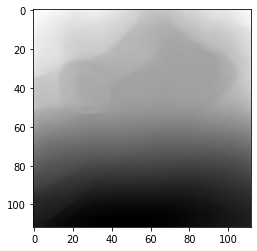

(112, 112, 3)
36.0
(112, 112) -1


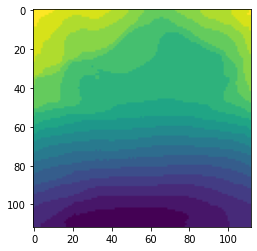

43.979427
(112, 112)


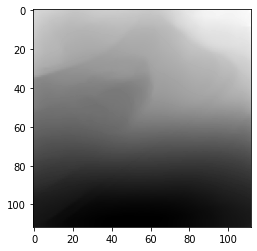

(112, 112, 3)
44.0
(112, 112) -1


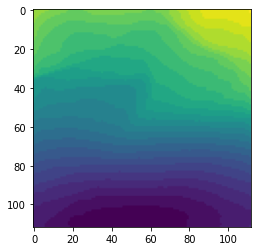

52.535057
(112, 112)


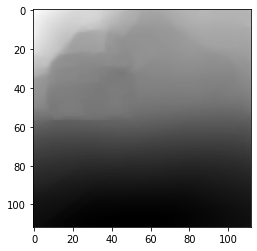

(112, 112, 3)
53.0
(112, 112) -1


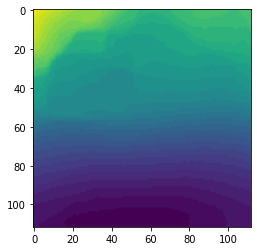

38.344406
(112, 112)


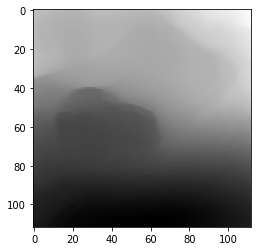

(112, 112, 3)
38.0
(112, 112) -1


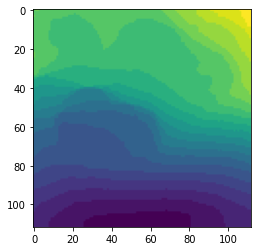

38.79914
(112, 112)


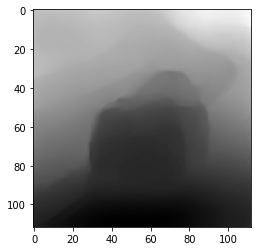

(112, 112, 3)
39.0
(112, 112) -1


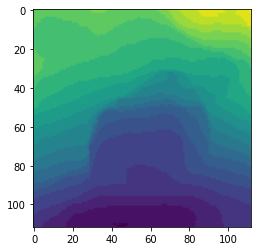

In [127]:
for i in range(5):
    #cm = plt.get_cmap('plasma')
    img=cv2.resize(outputs[i],(112,112))*255
    print(np.amax(img))
    #im=outputs[i]
    print(img.shape)
    #colored_image = cm(img)
    plt.imshow(img,cmap='gray')
    plt.show()
    cv2.imwrite('/content/bg1_'+str(i+1)+'.png',img)
    img_def=cv2.imread('/content/bg1_'+str(i+1)+'.png')
    print(img_def.shape)

    img_1=cv2.imread('/content/bg1_'+str(i+1)+'.png',cv2.IMREAD_UNCHANGED).astype('float32')
    print(np.amax(img_1))
    print(img_1.shape,cv2.IMREAD_UNCHANGED)
    plt.imshow(img_1)
    plt.show()



(224, 224, 3)
0


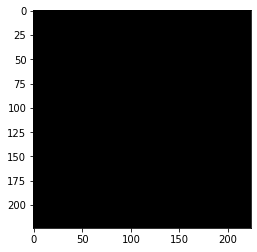

In [83]:
img=cv2.imread('/content/bg1_1.png')
print(img.shape)
print(np.amax(img))
plt.imshow(img)
plt.show()

In [0]:
#Unzip Files to local
%%bash
unzip -d /content ./Mask_RCNN/fg_bg.zip
unzip -d /content ./Mask_RCNN/fg_bg_mask.zip

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
img_list=os.listdir('/content/Mask_RCNN/fg_bg')
img_list[100]

'bg_8fg_89_flip-12.jpg'

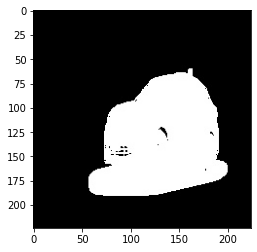

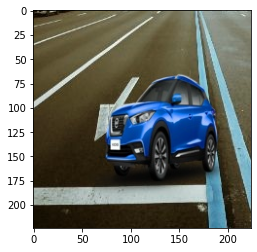

In [28]:
img=cv2.imread('/content/Mask_RCNN/fg_bg_mask/bg_2fg_103_19.jpg')
plt.imshow(img)
#!cv2.imwrite('/content/DenseDepth/test1.jpg',img2)
plt.show()

img=cv2.imread('/content/Mask_RCNN/fg_bg/bg_2fg_103_19.jpg')
plt.imshow(img)
#!cv2.imwrite('/content/DenseDepth/test1.jpg',img2)
plt.show()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

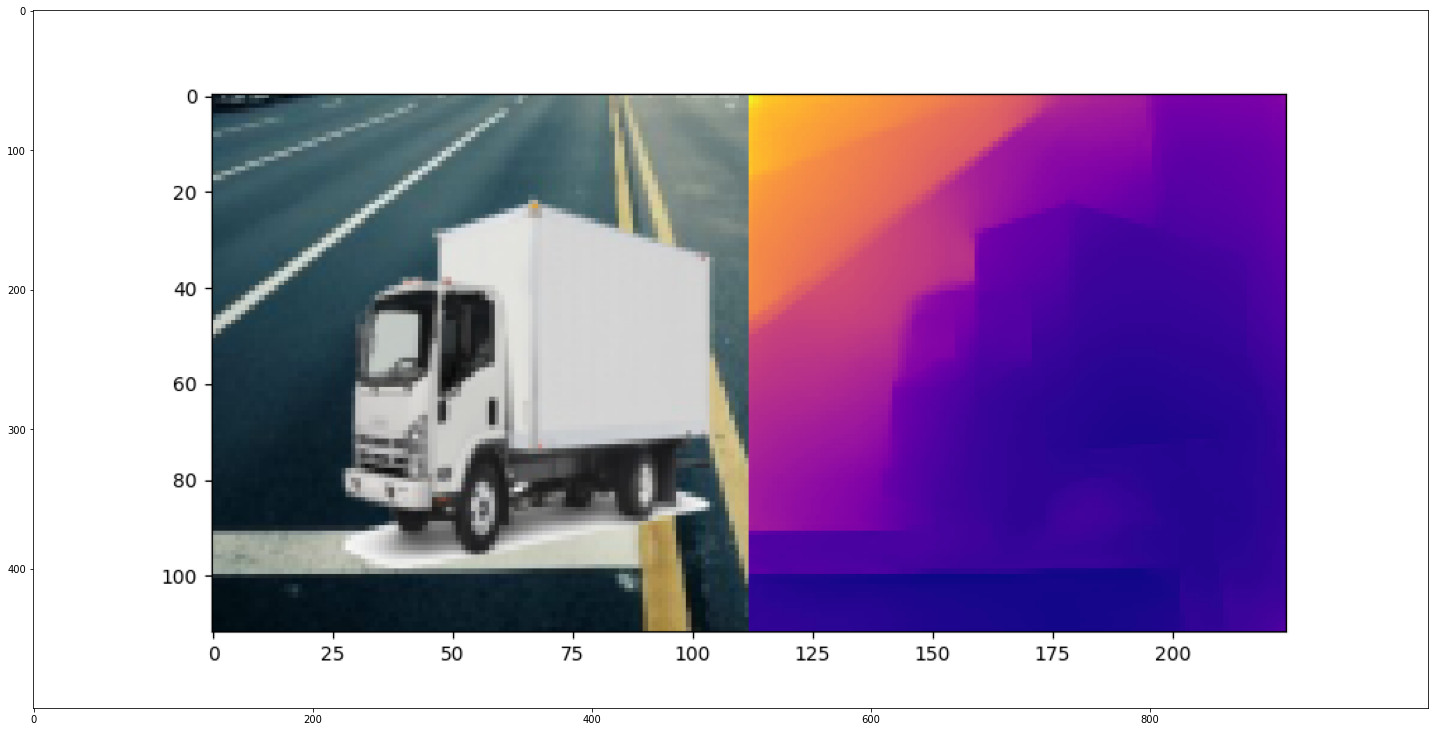

In [32]:
!cd DenseDepth; python test.py --model kitti.h5 --input '/content/Mask_RCNN/fg_bg/bg_2fg_14_19.jpg'
plt.figure(figsize=(25,25))
plt.imshow( io.imread('./DenseDepth/test.png') )

<Figure size 432x288 with 0 Axes>

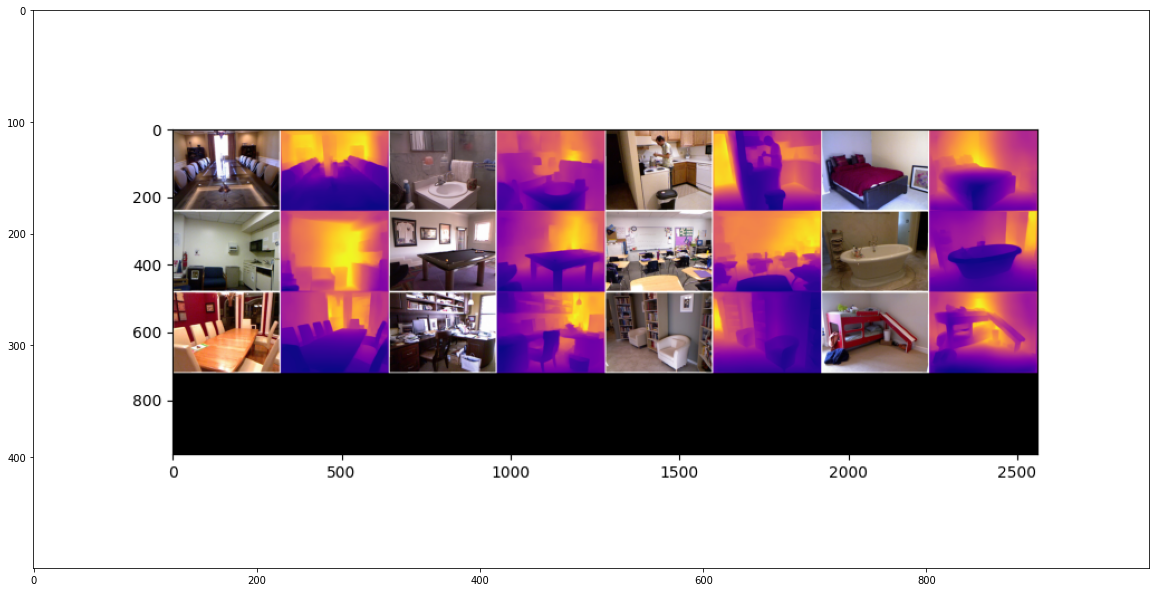

In [0]:
plt.clf()
plt.figure(figsize=(20,20))
plt.imshow( io.imread('./DenseDepth/test.png'), cmap='binary' )
plt.show()

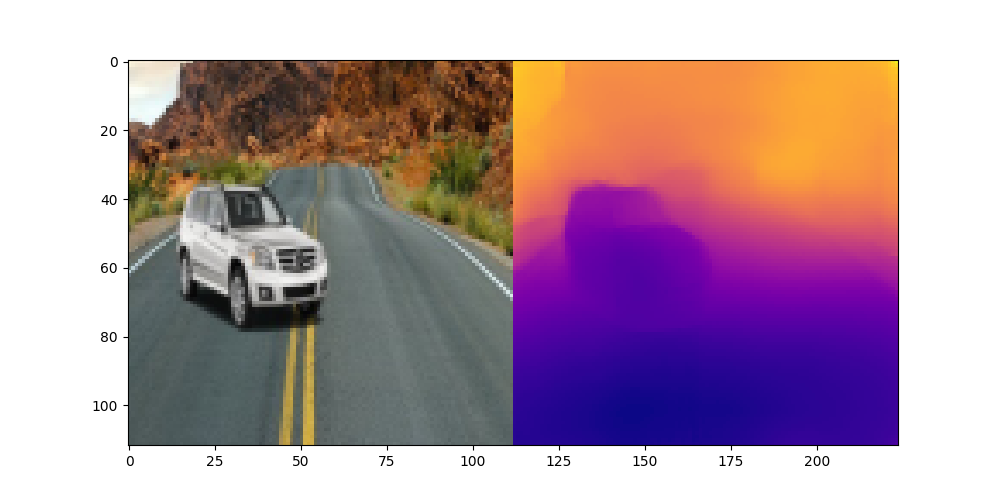

In [0]:
from IPython.display import Image, display
display(Image('./DenseDepth/test.png'))


In [30]:
!pip install tensorflow-gpu==1.13.1
!pip install q keras==2.2.4

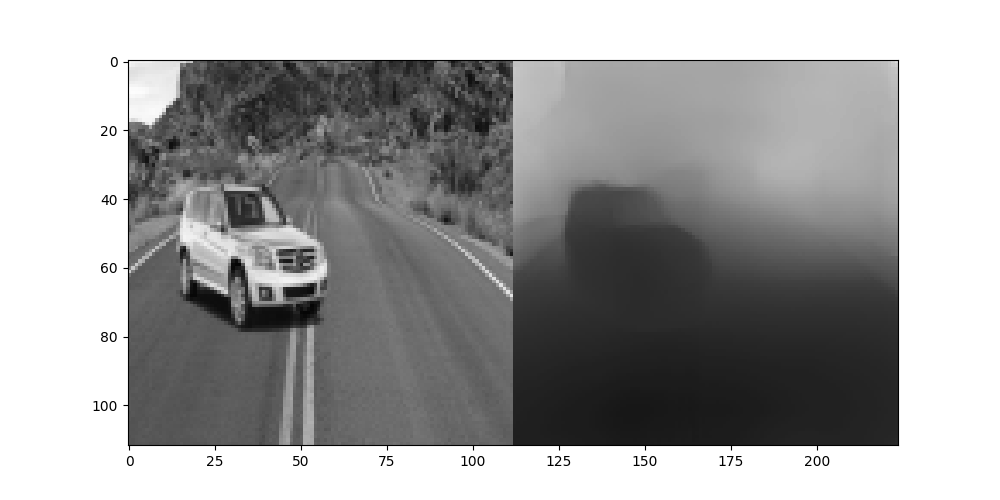

In [0]:
#imgdata = in_zip.read('/content/DenseDepth/test.png')
img = Image.open('/content/DenseDepth/test.png').convert('L')
img